**Code Implementation**

### Importing necessary packages and modules

In [1]:
!pip install git+https://github.com/openai/CLIP.git
# Installing Clip model

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qzkzggk8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qzkzggk8
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 781.0 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=aacf3aeb3f791588124b1abc0e91b2838a80bc89bf795ea778f20f9fd62d7186
  Stored in directory: /tmp/pip-ephem-wheel-cache-uydfpxzc/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
from pathlib import Path

import clip
import cv2
import matplotlib.pyplot as plt
import torch
from PIL import Image
from tqdm import tqdm

# sns.set_theme()
# torch.set_printoptions(sci_mode=False)

Download Clip model

In [3]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.3/157.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.5 MB/s eta 0:00:00


In [4]:
from pathlib import Path

data_dir = Path("data_dir")
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  # will download ~340mb model
print(device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.2MiB/s]


cuda


In [21]:
video_path = data_dir / 'stunts'
if not video_path.is_file():
    !yt-dlp -f 133 -o {video_path}  \
        'https://youtu.be/frYIj2FGmMA?si=no4WjquSPWsFjySZ'
# Sample video: https://youtu.be/lxuH5iVoXfQ?si=xrNjacJ5jZTW94BP
# Query Text:  Nancy's Dance Studio

### Video Processing and Feature extraction

In [6]:
cap = cv2.VideoCapture(str(video_path))

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Get the frames per second (FPS) of the video
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Total frames: {total_frames}, FPS: {fps}")




Total frames: 7465, FPS: 24.0


In [7]:
import cv2
import torch
from PIL import Image  # Import Image module from PIL
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm
import time
import multiprocessing

# Define CLIP model and preprocessing pipeline
preprocess = Compose([
    Resize((224, 224)),
    CenterCrop((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_visual_features(video_path, model, preprocess):
    # cap = cv2.VideoCapture(str(video_path))
    # frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print("fps", int(cap.get(cv2.CAP_PROP_FPS)))

    image_vectors = []
    batch_size = 800
    for i in tqdm(range(0, total_frames, batch_size)):
        frames_batch = []
        for j in range(batch_size):
            ret, frame = cap.read()
            if not ret:
                break
            # Convert NumPy array to PIL Image
            frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frames_batch.append(frame)

        with torch.no_grad():
            # Apply preprocessing pipeline to each frame
            frames_batch = [preprocess(frame).to(device) for frame in frames_batch]
            # Encode images
            encoded_batch = model.encode_image(torch.stack(frames_batch))

        image_vectors.extend(encoded_batch.cpu().tolist())

    cap.release()

    return image_vectors


st = time.time()
visual_features = extract_visual_features(video_path, model, preprocess)
# frame_index, similarity_scores = semantic_search(video_path, text_query, visual_features, model)
end = time.time()
print("Execution time: ", end - st)


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]

Execution time:  34.36315846443176


### Code for Semantic search and retrieval of frame_index and  similarity_scores

In [15]:
def semantic_search(video_path, text_query, visual_features, model, device):
    # Convert visual_features list to a tensor
    video_visual_features = torch.tensor(visual_features, device=device)

    # Encode text query
    text_query_embedding = model.encode_text(clip.tokenize([text_query]).to(device))

    # Calculate cosine similarity between query and video frames
    similarities = torch.cosine_similarity(video_visual_features, text_query_embedding)

    # Get index of most similar frame
    index = similarities.argmax().item()

    return index, similarities

# Usage

text_query ="A man climbing a ladder"

st = time.time()
frame_index, similarity_scores = semantic_search(video_path, text_query, visual_features, model, device)
end = time.time()

print("Execution time: ", end - st)


Execution time:  0.5452373027801514


In [16]:
print("Frame", frame_index )

Frame 2989


### Output: Display of most relevant Frame and Graph ploting similarity and frame number


In [17]:
import matplotlib.pyplot as plt

def display_frame_with_matplotlib(video_path, frame_index):
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    if ret:
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Display frame using matplotlib
        plt.imshow(frame_rgb)
        plt.title("Most Similar Frame")
        plt.axis('off')  # Hide axis
        plt.show()
    cap.release()
    retrieved_time_stamp()


logit_scale = model.logit_scale.exp().item()

def plot_search(query, similarities):
    plt.figure(figsize=(8, 4))
    plt.plot((logit_scale * similarities).softmax(dim=0).tolist())
    plt.title(f"Search of video frames for '{query}'")
    plt.xlabel("Frame number")
    plt.ylabel("Query-frame similarity (softmaxed)")
    plt.show()

def retrieved_time_stamp():
  # Calculate the duration of the video in seconds
    duration_seconds = total_frames / fps
    # Calculate the time stamp of the frame
    time_stamp = frame_index / fps

    # Convert time stamp to minutes and seconds
    minutes = int(time_stamp // 60)
    seconds = int(time_stamp % 60)

    print(f"\nTime stamp is {minutes}:{seconds:02d}")

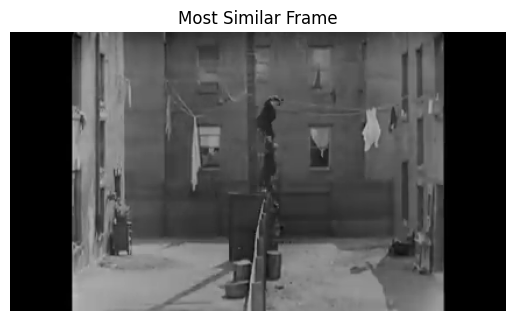


Time stamp is 2:04


In [18]:
display_frame_with_matplotlib(video_path, frame_index)


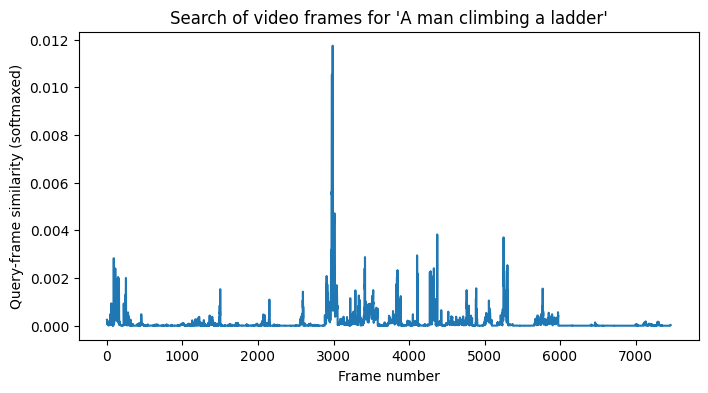

In [19]:

plot_search(text_query, similarity_scores)
